# FPL Predictor EDA


Our project aims to predict Fantasy Premier League (FPL) points for individual players in upcoming gameweeks. The foundation of this prediction task is a rich time-series dataset detailing player performances and match contexts across multiple FPL seasons. Initially, our data for each player-gameweek instance included:

*   **Player Identifiers:** Such as `name` (player's name) and `element` (unique player ID).
*   **Match Context:** `fixture` (match ID), `team` (player's team ID), `opponent_team` (opponent's team ID), `was_home` (home/away status), `kickoff_time`, and `GW` or `round` (gameweek number).
*   **Player FPL Attributes:** `position` (GK, DEF, MID, FWD), `value` (FPL price), `selected` (ownership percentage), and transfer statistics (`transfers_in`, `transfers_out`, `transfers_balance`).
*   **Performance Outcomes (for that specific gameweek):** This is a crucial category. It includes raw statistics like `minutes` played, `goals_scored`, `assists`, `clean_sheets`, `bonus` points, `bps` (Bonus Points System), `ict_index` (Influence, Creativity, Threat), various "expected" stats (`xP`, `expected_goals`, `expected_assists`, etc.), and finally, our primary **target variable: `total_points`**.

It's vital to recognize that the raw performance outcomes are direct results of the match they describe. While essential for calculating the target variable (`total_points`) for historical data and for creating lagged features, they cannot be used as direct inputs when predicting points for a *future, unplayed* match, as this would constitute data leakage.

Think about adding previous years

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Read the CSV file into a pandas DataFrame
df = pd.read_csv("C:/Users/asus/OneDrive/Desktop/projects/AI_project/data/merged_gw.csv")

df.columns

Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [49]:
df.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Femi Seriki,DEF,Sheffield Utd,0.5,0,0,0,0,0.0,653,...,0,0.0,0,0,0,0,40,True,0,1
1,Jack Hinshelwood,MID,Brighton,1.5,0,0,0,0,0.0,621,...,4,0.0,0,0,0,0,45,True,0,1
2,Jadon Sancho,MID,Man Utd,3.0,0,0,4,0,11.3,397,...,1,8.0,1,0,0,0,70,True,0,1
3,Rhys Norrington-Davies,DEF,Sheffield Utd,0.1,0,0,0,0,0.0,487,...,0,0.0,0,0,0,0,40,True,0,1
4,Vitaly Janelt,MID,Brentford,2.1,0,0,6,0,11.5,105,...,2,17.0,2,0,0,0,55,True,0,1


In [50]:
print("\nDataFrame Info:")
df.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29725 entries, 0 to 29724
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        29725 non-null  object 
 1   position                    29725 non-null  object 
 2   team                        29725 non-null  object 
 3   xP                          29725 non-null  float64
 4   assists                     29725 non-null  int64  
 5   bonus                       29725 non-null  int64  
 6   bps                         29725 non-null  int64  
 7   clean_sheets                29725 non-null  int64  
 8   creativity                  29725 non-null  float64
 9   element                     29725 non-null  int64  
 10  expected_assists            29725 non-null  float64
 11  expected_goal_involvements  29725 non-null  float64
 12  expected_goals              29725 non-null  float64
 13  expected_goals

In [51]:
#turning bool into int
df['was_home'] = df['was_home'].astype(int)


print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Missing values per column:
Series([], dtype: int64)


### Duplicates

There is not a full duplicate but there is possibility of a gameweek repeating. To simplify we will get the mean score to show the average performance in two matches

In [52]:
dup_mask = df.duplicated(keep=False)

total_rows    = len(df)
total_dups    = dup_mask.sum()
pct_dups      = total_dups / total_rows * 100

print(f"Total rows:           {total_rows}")
print(f"Rows with duplicates: {total_dups}  ({pct_dups:.2f}%)")

Total rows:           29725
Rows with duplicates: 0  (0.00%)


In [53]:
dup_mask = df.duplicated(subset=["name","GW"], keep=False)

total_rows    = len(df)
total_dups    = dup_mask.sum()
pct_dups      = total_dups / total_rows * 100

print(f"Total rows:           {total_rows}")
print(f"Rows with duplicates: {total_dups}  ({pct_dups:.2f}%)")


Total rows:           29725
Rows with duplicates: 1966  (6.61%)


In [54]:
# we lose some information as important data like opposing team can't be calculated as a mean 
# however still a better method than dropping a row, acting like a match didn't happen
columns_to_keep = ["name","position","team","fixture", "kickoff_time", "opponent_team", "was_home"]

agg_map = {
    col: 'first' for col in columns_to_keep
}

for col in df.columns:
    if col not in agg_map:
        agg_map[col] = 'mean'

# Now group and aggregate
df = df.groupby(['name', 'GW'], as_index=False).agg(agg_map)

df.head()

,name,position,team,fixture,kickoff_time,opponent_team,was_home,xP,assists,bonus,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW
0,Aaron Connolly,FWD,Brighton,4,2023-08-12T14:00:00Z,12,1,0.0,0.0,0.0,...,1.0,4.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,1.0
1,Aaron Connolly,FWD,Brighton,20,2023-08-19T14:00:00Z,20,0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.0,-1441.0,0.0,1441.0,45.0,0.0,2.0
2,Aaron Connolly,FWD,Brighton,24,2023-08-26T16:30:00Z,19,1,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,-719.0,0.0,719.0,45.0,0.0,3.0
3,Aaron Connolly,FWD,Brighton,33,2023-09-02T16:30:00Z,15,1,0.0,0.0,0.0,...,1.0,3.0,0.0,0.0,-415.0,0.0,415.0,45.0,0.0,4.0
4,Aaron Connolly,FWD,Brighton,45,2023-09-16T14:00:00Z,14,0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,-359.0,0.0,359.0,45.0,0.0,5.0


### Distrubition of our target variable

As we can see from the distrubition, majority of gameweeks yield somewhere between 0 and 3 points with a heavy tail to the right as getting high points is possible with high goals and assist while getting low scores are extremely harder. 

Also there is a sharp drop off after 3–5 points as once you’ve scored 5 or 6 points you’re already outperforming most of the field. 

Keeping in mind that there are also an undeniable large amount of players that just stay on the bench (getting 0 points as a result) center of distrubition lying near 0 makes sense.

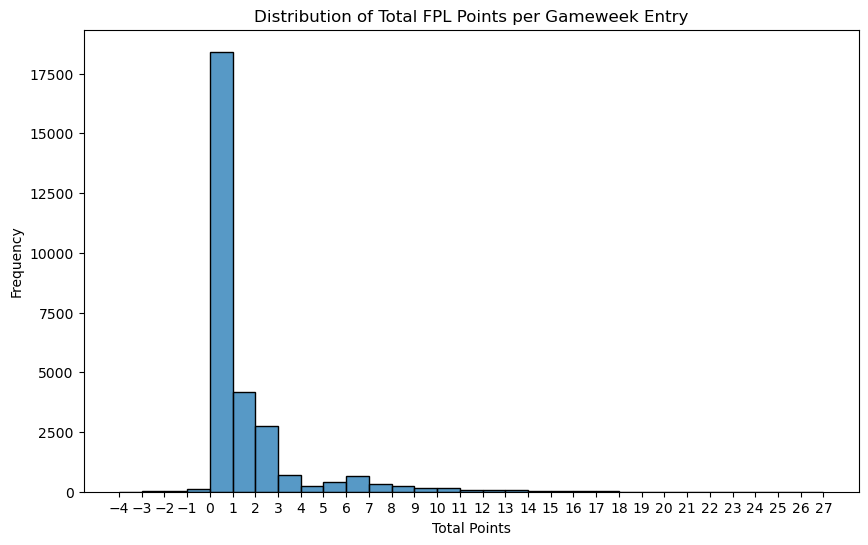


Value counts for total_points:
total_points
-4.0    0.000139
-3.0    0.000348
-2.0    0.001496
-1.0    0.003618
-0.5    0.000035
 0.0    0.638230
 0.5    0.002505
 1.0    0.143936
 1.5    0.001983
 2.0    0.094635
Name: proportion, dtype: float64


In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(df['total_points'], bins=range(int(df['total_points'].min()), int(df['total_points'].max()) + 2), kde=False)
plt.title('Distribution of Total FPL Points per Gameweek Entry')
plt.xlabel('Total Points')
plt.ylabel('Frequency')
plt.xticks(range(int(df['total_points'].min()), int(df['total_points'].max()) + 2, 1))
plt.show()

print(f"\nValue counts for total_points:\n{df['total_points'].value_counts(normalize=True).sort_index().head(10)}")

Important take aways

* Unimodal but skewed right: most point‐tallies cluster at the low end, with a long tail for the occasional outliers.

* Reflects event-driven scoring: small returns are common, big returns are rare.

* Outliers: High performances from high value players can be expected but not guaranteed while unexpected performances are one of the main entertainment factor of the game. Therefore, it might be a problem to expect the unexpected performance 

## Sparsity analysis

### Feature Engineering 

Raw, single-gameweek statistics provide a snapshot but often lack the context needed for robust prediction. To enhance our dataset's predictive capability, we performed extensive feature engineering, focusing on capturing player form, fixture difficulty, and temporal dynamics:

1.  **Lagged Player Performance:** To model player's recent form and momentum, we created lagged features for key performance metrics (e.g., `goals_scored_lag_1`, `minutes_lag_1`, `total_points_lag_3`). These represent a player's stats from the immediately preceding gameweeks.

2.  **Rolling Aggregates:** Beyond direct lags, we calculated rolling window statistics (e.g., `ict_index_roll_mean3_lag1`, `total_points_roll_sum5_lag1`). These features smooth out short-term variance and provide a more stable view of recent performance over a defined window (e.g., last 3 or 5 gameweeks, excluding the current one).

3.  **Team and Opponent Strength Integration:** We incorporated external team-level data (`df_team`) which provided pre-match strength ratings for each team. For every player-gameweek instance, we merged:
    *   The strength of the player's own team.
    *   The strength of the opponent team.
    These features (`player_team_attack_strength`, `opponent_team_defence_strength`, etc.) quantify fixture difficulty.

4.  **Handling "Expected" Stats (xG, xA, xP):** A critical assumption was made regarding columns like `xP`, `expected_goals`, `expected_assists`. We treated them as **pre-match expectations** (i.e., available information before the gameweek's matches begin). Under this assumption, they can serve as direct input features for the current gameweek. If they were post-match calculations, they would only be suitable for lagging. Their lagged versions were also created to capture trends in expectations.   

CHANGE THIS

All newly created lagged and rolling features had `NaN` values for the initial gameweeks of a player's history (or season). These were typically filled with `0`, assuming no prior data implies zero prior contribution for performance metrics.

In [56]:
def create_lagged_features(data, group_cols, target_col, lags, window_size=None):
    """
    Creates lagged features and rolling window features for a target column. We can't access to some data in t 
    so we get t-1 or even further back in time.

    Args:
        data (pd.DataFrame): Input DataFrame.
        group_cols (list): List of columns to group by (e.g., ['player_id', 'season_start_year']).
        target_col (str): The column to create lagged features for.
        lags (list of int): List of lag periods (e.g., [1, 2, 3] for lag 1, 2, 3).
        agg_func (str, optional): Aggregation function for rolling window ('mean', 'sum', 'std', etc.).

    Returns:
        pd.DataFrame: DataFrame with new lagged features.
    """
    data = data.copy()
    for lag in lags:
        new_col_name = f'{target_col}_lag_{lag}'
        data[new_col_name] = data.groupby(group_cols)[target_col].shift(lag)
        data[new_col_name] = data[new_col_name].fillna(0)

    if window_size:
        # For rolling window, we want to calculate based on PAST values.
        # So we first shift by 1, then apply rolling.
        # Example: rolling mean of last 3 games EXCLUDING current game.
        rolling_col_name = f'{target_col}_roll_{"mean"}{window_size}_lag1'
        data[rolling_col_name] = data.groupby(group_cols)[target_col].shift(1).fillna(0).rolling(window=window_size, min_periods=1).mean()



    return data


In [57]:
lagged_features = ["assists", "bonus", "bps", "clean_sheets", "creativity", "goals_conceded", 
                           "goals_scored", "ict_index", "influence", "minutes", "own_goals", "penalties_missed", 
                           "penalties_saved", "red_cards", "saves", "starts", "threat", "yellow_cards", "total_points", 
                           "xP", "expected_assists", "expected_goal_involvements", "expected_goals", "expected_goals_conceded", 
                           "value", "selected", "transfers_balance", "transfers_in", "transfers_out"]

# we lag also total points as previous games total point can be important information.

group_by_cols = ['name']

df_fe = df.copy()


for col in lagged_features:
    if col in df_fe.columns:
        df_fe = create_lagged_features(df_fe, group_cols=group_by_cols, target_col=col, lags=[1])

rolling_windows = [5] #change
for col in lagged_features:
    if col in df_fe.columns:
        for window in rolling_windows:
            df_fe = create_lagged_features(df_fe, group_cols=group_by_cols, target_col=col, lags=[], window_size=window)



print("\nDataFrame with lagged player features (sample):")

# Show an example for one player
df_fe[df_fe['name'] == "Mohamed Salah"][['GW', 'total_points'] + [col for col in df_fe.columns if 'total_points_lag' in col or 'total_points_roll' in col]].head(10)


DataFrame with lagged player features (sample):


,GW,total_points,total_points_lag_1,total_points_roll_mean5_lag1
20528,1.0,5.0,0.0,0.0
20529,2.0,5.0,5.0,1.0
20530,3.0,5.0,5.0,2.0
20531,4.0,8.0,5.0,3.0
20532,5.0,10.0,8.0,4.6
20533,6.0,10.0,10.0,6.6
20534,7.0,1.0,10.0,7.6
20535,8.0,15.0,1.0,6.8
20536,9.0,16.0,15.0,8.8
20537,10.0,8.0,16.0,10.4


give id for name, team, position



Teams data

In [58]:
df_team = pd.read_csv("C:/Users/asus/OneDrive/Desktop/projects/AI_project/data/teams.csv")

df_team.head()

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,NaN,1,0,Arsenal,0,0,0,ARS,...,NaN,False,0,1350,1365,1370,1370,1330,1360,1
1,7,0,NaN,2,0,Aston Villa,0,0,0,AVL,...,NaN,False,0,1160,1285,1140,1220,1180,1350,2
2,91,0,NaN,3,0,Bournemouth,0,0,0,BOU,...,NaN,False,0,1100,1100,1055,1130,1145,1075,127
3,94,0,NaN,4,0,Brentford,0,0,0,BRE,...,NaN,False,0,1100,1100,1110,1055,1090,1150,130
4,36,0,NaN,5,0,Brighton,0,0,0,BHA,...,NaN,False,0,1100,1210,1070,1180,1135,1240,131


In [59]:
team_id_map = df_team.set_index('name')['id'].to_dict()
df_fe['team_id'] = df_fe['team'].map(team_id_map)

df_fe['team_id']

0        5
1        5
2        5
3        5
4        5
        ..
28737    7
28738    7
28739    7
28740    7
28741    7
Name: team_id, Length: 28742, dtype: int64

Fixtures

In [60]:
fixtures = pd.read_csv("C:/Users/asus/OneDrive/Desktop/projects/AI_project/data/fixtures.csv")

fixtures.head()

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id
0,2367538,1,True,True,1,2023-08-11T19:00:00Z,90,False,True,13,3,6,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",5,2,93321
1,2367540,1,True,True,2,2023-08-12T12:00:00Z,90,False,True,16,1,1,2,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,5,93322
2,2367539,1,True,True,3,2023-08-12T14:00:00Z,90,False,True,19,1,3,1,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,2,93323
3,2367541,1,True,True,4,2023-08-12T14:00:00Z,90,False,True,12,1,5,4,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,3,93324
4,2367542,1,True,True,5,2023-08-12T14:00:00Z,90,False,True,10,1,9,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,2,93325


In [61]:
df_fe = df_fe.merge(fixtures[["id", "team_h", "team_a"]], left_on="fixture", right_on="id", how="left", suffixes=(None, "_fixture"))

strength_map = df_team.set_index("id")["strength"].to_dict()

# Add home and away strengths
df_fe["home_strength"] = df_fe["team_h"].map(strength_map)
df_fe["away_strength"] = df_fe["team_a"].map(strength_map)

In [62]:
df_fe["opponent_id"] = df_fe.apply(
    lambda row: row["team_a"] if row["team_id"] == row["team_h"] else row["team_h"], axis=1)

df_fe["opponent_strength"] = df_fe.apply(
    lambda row: row["away_strength"] if row["team_id"] == row["team_h"] else row["home_strength"], axis=1)

df_fe["team_strength"] = df_fe.apply(
    lambda row: row["home_strength"] if row["team_id"] == row["team_h"] else row["away_strength"], axis=1)

# 5. Clean up temporary columns if desired
df_fe = df_fe.drop(columns=["id", "team_h", "team_a", "home_strength" , "away_strength"])

df_fe.head()

,name,position,team,fixture,kickoff_time,opponent_team,was_home,xP,assists,bonus,...,expected_goals_conceded_roll_mean5_lag1,value_roll_mean5_lag1,selected_roll_mean5_lag1,transfers_balance_roll_mean5_lag1,transfers_in_roll_mean5_lag1,transfers_out_roll_mean5_lag1,team_id,opponent_id,opponent_strength,team_strength
0,Aaron Connolly,FWD,Brighton,4,2023-08-12T14:00:00Z,12,1,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.000000,5,12,2,3
1,Aaron Connolly,FWD,Brighton,20,2023-08-19T14:00:00Z,20,0,0.0,0.0,0.0,...,0.0,22.50,2810.5,0.000000,0.0,0.000000,5,20,3,3
2,Aaron Connolly,FWD,Brighton,24,2023-08-26T16:30:00Z,19,1,0.0,0.0,0.0,...,0.0,30.00,3238.0,-480.333333,0.0,480.333333,5,19,3,3
3,Aaron Connolly,FWD,Brighton,33,2023-09-02T16:30:00Z,15,1,0.0,0.0,0.0,...,0.0,33.75,3288.0,-540.000000,0.0,540.000000,5,15,3,3
4,Aaron Connolly,FWD,Brighton,45,2023-09-16T14:00:00Z,14,0,0.0,0.0,0.0,...,0.0,36.00,3240.0,-515.000000,0.0,515.000000,5,14,3,3


Turning categorical data into numerical (or getting rid of it)

We already got team ids and we disregard kickoff_time as it is irrelevant

In [63]:
df_fe.dtypes[df_fe.dtypes == object]

name            object
position        object
team            object
kickoff_time    object
dtype: object

Positions

In [64]:
pos_map = {
    "DEF": 1,
    "MID": 2,
    "FWD": 3,
    "GK":  4
}

df_fe["position_id"] = df["position"].map(pos_map)

df_fe.head()


,name,position,team,fixture,kickoff_time,opponent_team,was_home,xP,assists,bonus,...,value_roll_mean5_lag1,selected_roll_mean5_lag1,transfers_balance_roll_mean5_lag1,transfers_in_roll_mean5_lag1,transfers_out_roll_mean5_lag1,team_id,opponent_id,opponent_strength,team_strength,position_id
0,Aaron Connolly,FWD,Brighton,4,2023-08-12T14:00:00Z,12,1,0.0,0.0,0.0,...,0.00,0.0,0.000000,0.0,0.000000,5,12,2,3,3
1,Aaron Connolly,FWD,Brighton,20,2023-08-19T14:00:00Z,20,0,0.0,0.0,0.0,...,22.50,2810.5,0.000000,0.0,0.000000,5,20,3,3,3
2,Aaron Connolly,FWD,Brighton,24,2023-08-26T16:30:00Z,19,1,0.0,0.0,0.0,...,30.00,3238.0,-480.333333,0.0,480.333333,5,19,3,3,3
3,Aaron Connolly,FWD,Brighton,33,2023-09-02T16:30:00Z,15,1,0.0,0.0,0.0,...,33.75,3288.0,-540.000000,0.0,540.000000,5,15,3,3,3
4,Aaron Connolly,FWD,Brighton,45,2023-09-16T14:00:00Z,14,0,0.0,0.0,0.0,...,36.00,3240.0,-515.000000,0.0,515.000000,5,14,3,3,3


Player ids

In [65]:
df_fe['player_id'], uniques = pd.factorize(df_fe['name'])

df_fe[["name","player_id"]]



,name,player_id
0,Aaron Connolly,0
1,Aaron Connolly,0
2,Aaron Connolly,0
3,Aaron Connolly,0
4,Aaron Connolly,0
...,...,...
28737,Đorđe Petrović,868
28738,Đorđe Petrović,868
28739,Đorđe Petrović,868
28740,Đorđe Petrović,868


### Correlation Analysis


--- Correlation Analysis ---


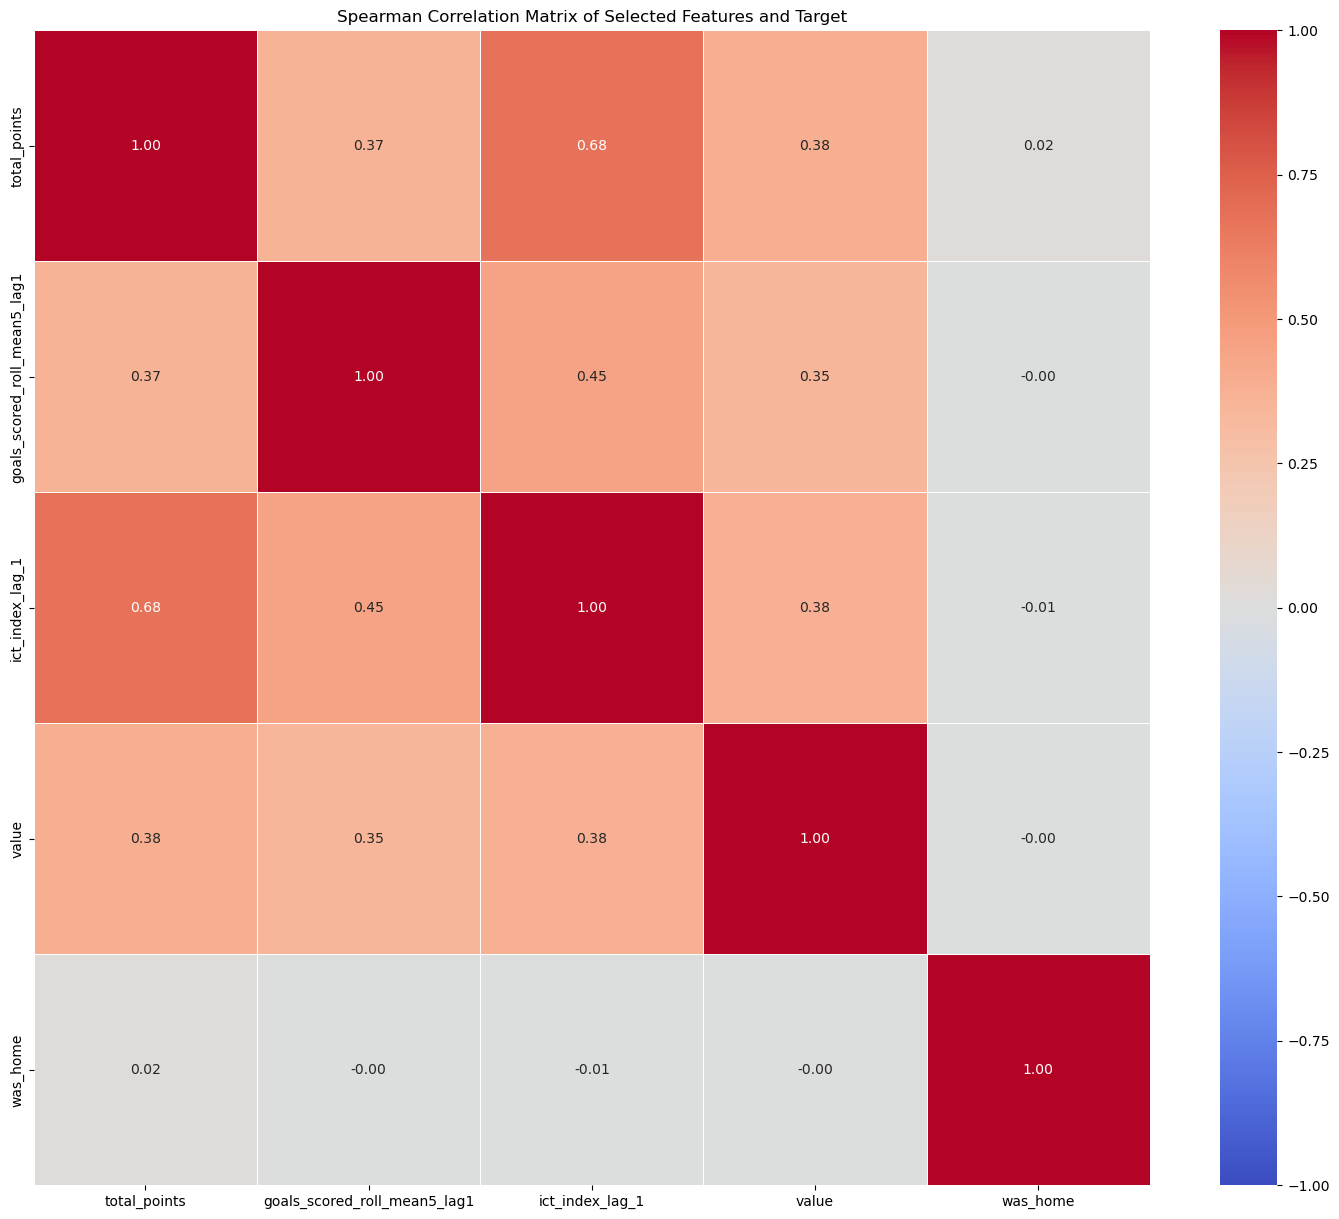


Top Spearman correlations with 'total_points':
total_points                    1.000000
ict_index_lag_1                 0.678928
value                           0.383049
goals_scored_roll_mean5_lag1    0.365821
was_home                        0.016693
Name: total_points, dtype: float64


In [67]:
print("\n--- Correlation Analysis ---")

# Let's pick some original performance stats, key engineered player stats, and key team/opponent stats
correlation_subset_cols = ["total_points", 'goals_scored_roll_mean5_lag1', 'ict_index_lag_1', 'value', 'was_home'] # add more

# Using Spearman correlation as it's less sensitive to non-linear relationships and outliers
corr_matrix_spearman = df_fe[correlation_subset_cols].corr(method='spearman')

plt.figure(figsize=(18, 15)) 
sns.heatmap(corr_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix of Selected Features and Target')
plt.show()

# Correlations with the target variable
print(f"\nTop Spearman correlations with '{"total_points"}':")
target_corr_spearman = corr_matrix_spearman["total_points"].sort_values(ascending=False)
print(target_corr_spearman)


When there are highly correlated data we both learn the features that are most important to a target variable as well as if some features are correlated between each other, it might make sense to drop one of them to make the model's job easier. In our case even if there colinear features each one here carries enough individual information to still consider them valuable for the model

### Saving the processed data

In [68]:
df_fe.head()

,name,position,team,fixture,kickoff_time,opponent_team,was_home,xP,assists,bonus,...,selected_roll_mean5_lag1,transfers_balance_roll_mean5_lag1,transfers_in_roll_mean5_lag1,transfers_out_roll_mean5_lag1,team_id,opponent_id,opponent_strength,team_strength,position_id,player_id
0,Aaron Connolly,FWD,Brighton,4,2023-08-12T14:00:00Z,12,1,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,5,12,2,3,3,0
1,Aaron Connolly,FWD,Brighton,20,2023-08-19T14:00:00Z,20,0,0.0,0.0,0.0,...,2810.5,0.000000,0.0,0.000000,5,20,3,3,3,0
2,Aaron Connolly,FWD,Brighton,24,2023-08-26T16:30:00Z,19,1,0.0,0.0,0.0,...,3238.0,-480.333333,0.0,480.333333,5,19,3,3,3,0
3,Aaron Connolly,FWD,Brighton,33,2023-09-02T16:30:00Z,15,1,0.0,0.0,0.0,...,3288.0,-540.000000,0.0,540.000000,5,15,3,3,3,0
4,Aaron Connolly,FWD,Brighton,45,2023-09-16T14:00:00Z,14,0,0.0,0.0,0.0,...,3240.0,-515.000000,0.0,515.000000,5,14,3,3,3,0


In [69]:
df_fe.to_csv("C:/Users/asus/OneDrive/Desktop/projects/AI_project/data/processed_data.csv", index=False)